In [33]:
import pandas as pd
import cv2
import numpy as np
import matplotlib.pyplot as plt
import sklearn.cluster as cluster
import sklearn.mixture as mixture
from sklearn.metrics import silhouette_score
import scipy.cluster.hierarchy as hierarchy

read the csv after finding horizontal threshold, vertical thresholds. make it such that it follows the given format

final csv is the csv that has columns Id, Top-Left, Bottom-Right, Top, Left, Bottom, Right, Top_box, Bottom_box, Left_box, Right_box

Id - refers to box ID -> int

Top-Left,Bottom-Right - refers to the xy coordinates of topleft and bottomright coordinate of a bounding box

Top/Left/Bottom/Right - refers to the coordinates of edge centers

Top_box/Bottom_box/Left_box/Right_box - refers to the nearest box from current box such that the words across paragraphs or columns should not get connected -> List:[dist, nearest box ID]


In [ ]:
df = pd.read_csv('SMAI - AQ2/CSV/TLBR_68.csv')
boxes = []
centres = []
points = []
for i, rows in df.iterrows():
    id = rows['Id']
    top_left = (int(rows['Top-Left'].split(',')[0][1:]),int(rows['Top-Left'].split(',')[1][:-1]))
    bottom_right = (int(rows['Bottom-Right'].split(',')[0][1:]),int(rows['Bottom-Right'].split(',')[1][:-1]))
    boxes.append([top_left, bottom_right])
    
    centre = [(top_left[0]+bottom_right[0])/2, (top_left[1]+bottom_right[1])/2]
    centres.append(centre)
    
    top = [(top_left[0] + bottom_right[0])/2, top_left[1]]
    bottom = [(top_left[0] + bottom_right[0])/2, bottom_right[1]]
    left = [top_left[0], (top_left[1] + bottom_right[1])/2]
    right = [bottom_right[0], (top_left[1] + bottom_right[1])/2]
    
    points.append([id, top_left, bottom_right, centre, top, bottom, left, right]) 
centres = np.array(centres)

x = hierarchy.linkage(centres, 'single')
hierarchy.dendrogram(x, orientation='left')

SIL = []
for i in range(50, 250):
    distance_threshold = i
    clusters = hierarchy.fcluster(x, distance_threshold, criterion='distance')
    
    sil = silhouette_score(x, clusters)
    SIL.append(sil)
    
plt.plot(np.arange(50, 250), SIL)
plt.show()

In [28]:
distance_threshold = 125

clusters = hierarchy.fcluster(x, distance_threshold, criterion='distance')
# points = [[]]
# for i in range(len(points)):
#     points[i].extend([clusters[i]])
    
# print(points)

unique_clusters = np.unique(clusters)

# get a 2d array of points for each cluster ordered by Id
cluster_points = [[] for i in range(len(unique_clusters))]



# print(unique_clusters)
for i in range(len(points)):
    cluster_points[clusters[i]-1].append(points[i])
    
points2 = []

count = np.zeros(len(points))
    
for i in range(len(cluster_points)):
    dict = {}
    cluster_points[i] = sorted(cluster_points[i], key=lambda x: x[0])
    for j in range(len(cluster_points[i])):
        dict[cluster_points[i][j][0]] = []
    for j in range(len(cluster_points[i])):
        # find closest point to the top of cluster_points[i][j]
        if count[cluster_points[i][j][0]] > 4:
            continue
        indices = []
        top = cluster_points[i][j][4]
        min_dist = 1000000000
        min_index = -1
        for k in range(len(cluster_points[i])):
            if k != j and cluster_points[i][k][0] not in indices and cluster_points[i][j][0] not in dict[cluster_points[i][k][0]] and count[cluster_points[i][k][0]] < 4:
                dist = np.linalg.norm(np.array(top) - np.array(cluster_points[i][k][3]))
                if dist < min_dist:
                    min_dist = dist
                    min_index = cluster_points[i][k][0]
                    
        if min_index == -1:
            count[cluster_points[i][j][0]] += 1
            count[cluster_points[i][min_index][0]] += 1
        cluster_points[i][j].extend([[min_dist, min_index]])
        indices.append(min_index)
        
        bottom = cluster_points[i][j][5]
        min_dist = 1000000000
        min_index = -1
        for k in range(len(cluster_points[i])):
            if k != j and cluster_points[i][k][0] not in indices and cluster_points[i][j][0] not in dict[cluster_points[i][k][0]] and count[cluster_points[i][k][0]] < 4:
                dist = np.linalg.norm(np.array(bottom) - np.array(cluster_points[i][k][3]))
                if dist < min_dist:
                    min_dist = dist
                    min_index = cluster_points[i][k][0]
        
        if min_index == -1:
            count[cluster_points[i][j][0]] += 1
            count[cluster_points[i][min_index][0]] += 1
        cluster_points[i][j].extend([[min_dist, min_index]])
        indices.append(min_index)
        
        left = cluster_points[i][j][6]
        min_dist = 1000000000
        min_index = -1
        for k in range(len(cluster_points[i])):
            if k != j and cluster_points[i][k][0] not in indices and cluster_points[i][j][0] not in dict[cluster_points[i][k][0]] and count[cluster_points[i][k][0]] < 4:
                dist = np.linalg.norm(np.array(left) - np.array(cluster_points[i][k][3]))
                if dist < min_dist:
                    min_dist = dist
                    min_index = cluster_points[i][k][0]
        
        if min_index == -1:
            count[cluster_points[i][j][0]] += 1
            count[cluster_points[i][min_index][0]] += 1
        cluster_points[i][j].extend([[min_dist, min_index]])
        indices.append(min_index)
        
        # print(cluster_points[i][j][0], min_index, min_dist)
        right = cluster_points[i][j][7]
        min_dist = 1000000000
        min_index = -1
        for k in range(len(cluster_points[i])):
            if k != j and cluster_points[i][k][0] not in indices and cluster_points[i][j][0] not in dict[cluster_points[i][k][0]] and count[cluster_points[i][k][0]] < 4:
                dist = np.linalg.norm(np.array(right) - np.array(cluster_points[i][k][3]))
                if dist < min_dist:
                    min_dist = dist
                    min_index = cluster_points[i][k][0]
        
        if min_index == -1:
            count[cluster_points[i][j][0]] += 1
            count[cluster_points[i][min_index][0]] += 1
        cluster_points[i][j].extend([[min_dist, min_index]])   
        indices.append(min_index)
        
        dict[cluster_points[i][j][0]].extend(indices)
        
        points2.append(cluster_points[i][j])
        
points2 = [[i[0], i[1], i[2], i[3], i[4], i[5], i[6], i[7], i[8], i[9], i[10], i[11], clusters[i[0]]] for i in points2]
points2 = sorted(points2, key=lambda x: x[0])
# print(points2)
headers = ['Id', 'Top-Left', 'Bottom-Right', 'Centre', 'Top', 'Bottom', 'Left', 'Right', 'Top_Box', 'Bottom_Box', 'Left_Box', 'Right_Box', 'Cluster']

# create a new dataframe
new_csv = pd.DataFrame(points2, columns=headers)

# add the dataframe to a new csv
new_csv.to_csv('SMAI - AQ2/CSV/TLBR_68_2.csv')
        
new_csv

,Id,Top-Left,Bottom-Right,Centre,Top,Bottom,Left,Right,Top_Box,Bottom_Box,Left_Box,Right_Box,Cluster
0,0,"(290, 85)","(435, 147)","[362.5, 116.0]","[362.5, 85]","[362.5, 147]","[290, 116.0]","[435, 116.0]","[1000000000, -1]","[1000000000, -1]","[1000000000, -1]","[1000000000, -1]",9
1,1,"(563, 82)","(730, 147)","[646.5, 114.5]","[646.5, 82]","[646.5, 147]","[563, 114.5]","[730, 114.5]","[1000000000, -1]","[1000000000, -1]","[1000000000, -1]","[1000000000, -1]",8
2,2,"(744, 92)","(940, 140)","[842.0, 116.0]","[842.0, 92]","[842.0, 140]","[744, 116.0]","[940, 116.0]","[1000000000, -1]","[1000000000, -1]","[1000000000, -1]","[1000000000, -1]",10
3,3,"(1163, 92)","(1184, 147)","[1173.5, 119.5]","[1173.5, 92]","[1173.5, 147]","[1163, 119.5]","[1184, 119.5]","[110.59950271135942, 4]","[1000000000, -1]","[1000000000, -1]","[1000000000, -1]",1
4,4,"(1218, 79)","(1344, 157)","[1281.0, 118.0]","[1281.0, 79]","[1281.0, 157]","[1218, 118.0]","[1344, 118.0]","[1000000000, -1]","[1000000000, -1]","[1000000000, -1]","[1000000000, -1]",1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
493,493,"(1566, 3264)","(1740, 3315)","[1653.0, 3289.5]","[1653.0, 3264]","[1653.0, 3315]","[1566, 3289.5]","[1740, 3289.5]","[1000000000, -1]","[1000000000, -1]","[1000000000, -1]","[1000000000, -1]",15
494,494,"(1762, 3261)","(1851, 3315)","[1806.5, 3288.0]","[1806.5, 3261]","[1806.5, 3315]","[1762, 3288.0]","[1851, 3288.0]","[131.66054838105453, 482]","[224.31785483995696, 495]","[194.90510511528424, 481]","[216.63448478947205, 483]",14
495,495,"(1958, 3261)","(2100, 3312)","[2029.0, 3286.5]","[2029.0, 3261]","[2029.0, 3312]","[1958, 3286.5]","[2100, 3286.5]","[114.53602053502645, 496]","[190.62069667273803, 484]","[190.60167890131504, 482]","[129.59648914997658, 497]",14
496,496,"(2120, 3250)","(2163, 3315)","[2141.5, 3282.5]","[2141.5, 3250]","[2141.5, 3315]","[2120, 3282.5]","[2163, 3282.5]","[93.46790893135461, 497]","[185.65155533956616, 485]","[169.30002953337012, 484]","[227.4802189202393, 483]",14


In [29]:
img = cv2.imread('SMAI - AQ2/images/68.jpg')

Given below are two functions to visualize the document image and the connections established.

visualize_bboxes() can be used to visualize a document image with the bounding boxes around words. Bounding box information is given in the CSVs provided

make_connections() can be used to verify and visualize the connections established between words such that it satisfies the given criteria of grouping words in a logical paragraph. This function has to be used after getting the final csv in the specified format

In [30]:
def visualize_bboxes(img, dframe):
  img_2 = img.copy()
  for index, rows in dframe.iterrows():
    # top_left = (int(rows['Top-Left'].split(',')[0][1:]),int(rows['Top-Left'].split(',')[1][:-1]))
    # bottom_right = (int(rows['Bottom-Right'].split(',')[0][1:]),int(rows['Bottom-Right'].split(',')[1][:-1]))
    top_left = rows['Top-Left']
    bottom_right = rows['Bottom-Right']
    # print(top_left)
    cv2.rectangle(img_2, top_left, bottom_right, (255, 0, 0), 2)

  plt.imshow(img_2)
  cv2.imwrite('eg.jpg', img_2)

In [31]:
def make_connections(image, euclidean):

    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    image_with_boxes = image_rgb.copy()
    # print(len(points2))
    
    count = {}
    for i, row in euclidean.iterrows():
        count[row['Id']] = [0, 0, 0, 0]
    

    for index, row in euclidean.iterrows():
        # print(count[row['Id']])
        left = int(row['Left'][0])
        right = int(row['Right'][0])
        top = int(row['Top'][1])
        bottom = int(row['Bottom'][1])
        box_id = int(row['Id'])

        width = right - left
        height = bottom - top

        top_left = (left, top)
        bottom_right = (right, bottom)

        cv2.rectangle(image_with_boxes, top_left, bottom_right, (255, 0, 0), 2)

        label_position = (left, top - 10)
        cv2.putText(image_with_boxes, str(box_id)+" "+str(row['Cluster']), label_position, cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 1)

        top_adjacent_id = int(row['Top_Box'][1])
        bottom_adjacent_id = int(row['Bottom_Box'][1])
        left_adjacent_id = int(row['Left_Box'][1])
        right_adjacent_id = int(row['Right_Box'][1])
        
        # print(top_adjacent_id)
        
        # print(count[top_adjacent_id])

        if top_adjacent_id != -1 and count[top_adjacent_id][1] == 0:
            top_adjacent_row = euclidean[euclidean['Id'] == top_adjacent_id].iloc[0]
            top_adjacent_center = int(top_adjacent_row['Bottom'][0]) , int(top_adjacent_row['Bottom'][1])
            cv2.line(image_with_boxes, (int(left) + width // 2, int(top)), top_adjacent_center, (0, 255, 0), 2)
            count[box_id][0] = 1
            count[top_adjacent_id][1] = 1

        if bottom_adjacent_id != -1 and count[bottom_adjacent_id][0] == 0:
            bottom_adjacent_row = euclidean[euclidean['Id'] == bottom_adjacent_id].iloc[0]
            bottom_adjacent_center = int(bottom_adjacent_row['Top'][0]) , int(bottom_adjacent_row['Top'][1])
            cv2.line(image_with_boxes, (int(left) + width // 2, int(bottom)), (int(bottom_adjacent_center[0]), int(bottom_adjacent_center[1])), (0, 255, 0), 2)
            count[box_id][1] = 1
            count[bottom_adjacent_id][0] = 1

        if left_adjacent_id != -1 and count[left_adjacent_id][3] == 0:
            left_adjacent_row = euclidean[euclidean['Id'] == left_adjacent_id].iloc[0]
            left_adjacent_center = int(left_adjacent_row['Right'][0]) , int(left_adjacent_row['Right'][1])
            cv2.line(image_with_boxes, (int(left), int(top) + height // 2), (int(left_adjacent_center[0]), int(left_adjacent_center[1])), (0, 255, 0), 2)
            count[box_id][2] = 1
            count[left_adjacent_id][3] = 1

        if right_adjacent_id != -1 and count[right_adjacent_id][2] == 0:
            right_adjacent_row = euclidean[euclidean['Id'] == right_adjacent_id].iloc[0]
            right_adjacent_center = int(right_adjacent_row['Left'][0]) , int(right_adjacent_row['Left'][1])
            cv2.line(image_with_boxes, (int(right), int(top) + height // 2), (int(right_adjacent_center[0]), int(right_adjacent_center[1])), (0, 255, 0), 2)
            count[box_id][3] = 1
            count[right_adjacent_id][2] = 1

    return image_with_boxes

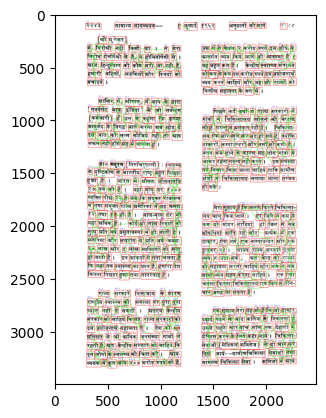

In [32]:
visualize_bboxes(img, new_csv)
img2 = make_connections(img, new_csv)
visualize_bboxes(img2, new_csv)